In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

# Paths to where we store the training data and the models

In [5]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
modelpath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/models/'

# First test a single model on single dataset

For all my models, I store the model object together with a list of the feature names that went into the training and define the inputs for predicting with the model, as well as the folder name that specifies the set of summary features that was used. If I used all the features, then I save features=None, and all the testing functions I wrote will simply use all the features in the dataset when the features list = None.

So let's take a single case, e.g. model trained with ressummaryfeatures on the random dataset, and we want to test it on the resonant dataset:

In [6]:
modelfilename = 'ressummaryfeaturesxgb_resonantAMD.pkl' # my filenames are NameOfFeatureSetxgb_datasetusedfortraining.pkl
testing_dataset = 'resonant/'

In [7]:
model, features, featurefolder = dill.load(open(modelpath+modelfilename, "rb"))
testingdatafolder = datapath+testing_dataset+featurefolder

# Now we use the functions from modelfitting.py to make various diagnostic plots

# ROC Curve

Text(0.5, 1.0, 'ROC curve (AUC = 0.958)')

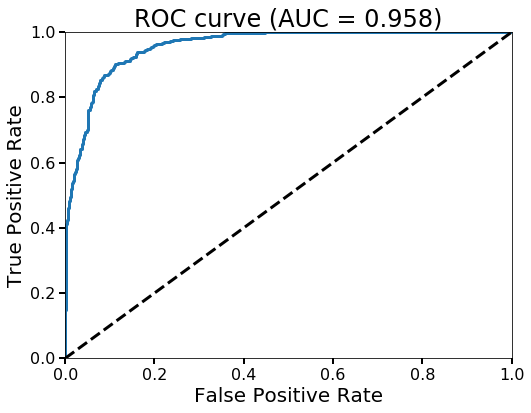

In [8]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# Precision Recall Curve

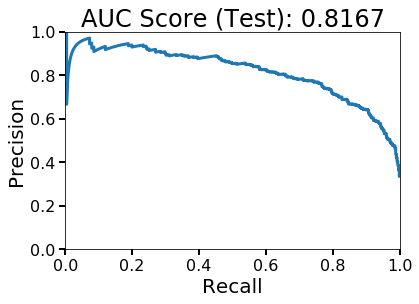

In [6]:
pr_auc, precision, recall, PRthresholds = PR_curve(testingdatafolder, model, features)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

# Histograms of systems by model's outputted prediction probability, broken down by systems that are actually unstable (blue) and actually stable (green)

Note that the leftmost blue histograms go much higher. Cut off to show the misclassifications at lower levels

(0, 66.0)

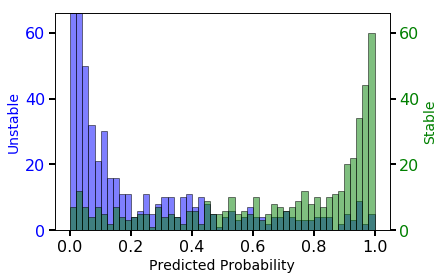

In [7]:
bins = 50
Stable, Unstable = stable_unstable_hist(testingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
ax1.set_ylim([0,1.1*n[-1]])
ax2.set_ylim([0,1.1*n[-1]])

# This is a test of how close the predictions are to what they claim, i.e., for predicted probabilities of stability within a bin's range, what fraction of those were actually stable?

Text(0, 0.5, 'Fraction actually stable')

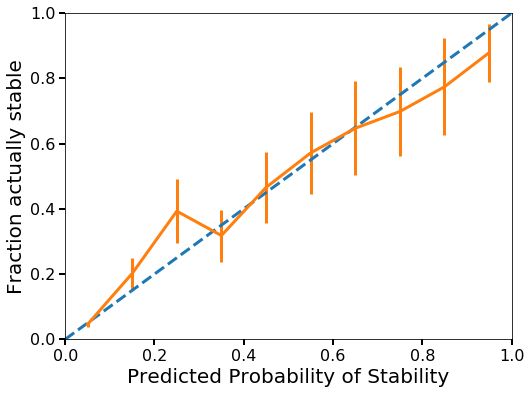

In [8]:
bincenters, fracstable, errorbars = calibration_plot(testingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

# Check how the prediction fidelity varies with how long a system takes to go unstable

We can't subdivide the systems that stayed stable to 1e9 orbits, but we can take all the unstable systems and divide them into bins based on their actual instability times. We can then ask, in each of those bins, what fraction of the systems did the model mispredict, i.e., what fraction did the model say would be stable but the system was actually unstable? Shows, as expected, that it's harder to predict stability the longer the instability time is away from our short integrations of $10^4$ orbits

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

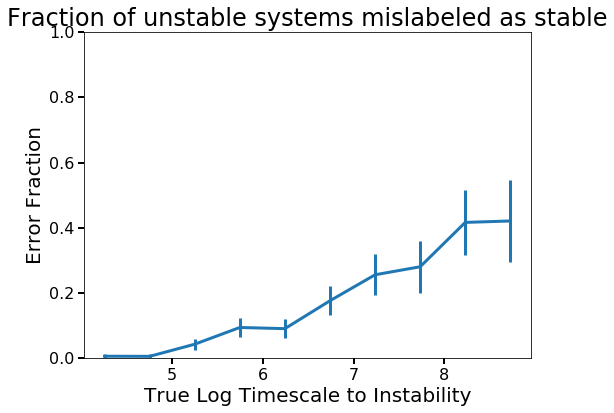

In [26]:
bincenters, errorfracs, errorbars = unstable_error_fraction(testingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('True Log Timescale to Instability')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

# We can also easily make grids. Take only models trained using resonant features, and make a 2x2 grid for trained on random/resonant on one axis, and tested on random/resonant on the other

In [20]:
training_features = ['megnoxgb'#'ressummaryfeaturesxgb', 'orbsummaryfeaturesxgb']#, #, 'shadowtimesxgb']
training_datasets = ['random', 'resonant']
testing_datasets = ['random', 'resonant']

Text(0.5, 0.98, 'Precision Recall Curves')

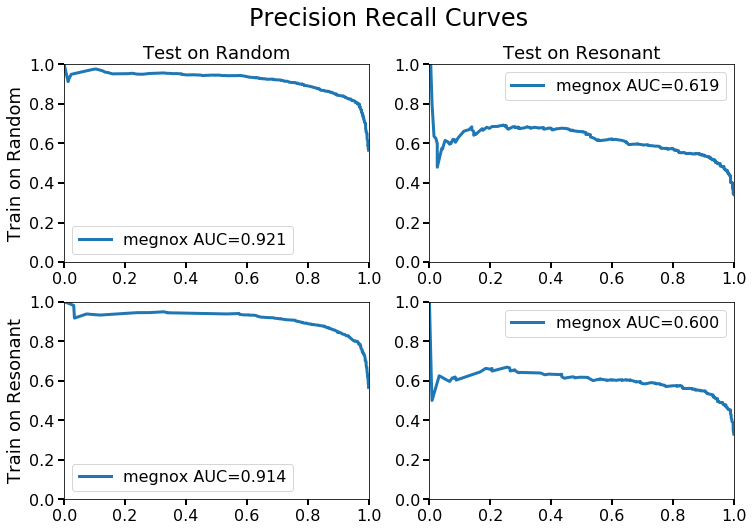

In [21]:
fig, axarr = plt.subplots(figsize=(12,8), nrows=len(training_datasets), ncols=len(testing_datasets))
for i, training_dataset in enumerate(training_datasets):
    for j, testing_dataset in enumerate(testing_datasets):
        for training_feature in training_features:
            modelfilename = '{0}_{1}.pkl'.format(training_feature, training_dataset) # my filenames are NameOfFeatureSetxgb_datasetusedfortraining.pkl
            model, features, featurefolder = dill.load(open(modelpath+modelfilename, "rb"))
            testingdatafolder = datapath+testing_dataset+'/'+featurefolder

            pr_auc, precision, recall, PRthresholds = PR_curve(testingdatafolder, model, features)
            axarr[i,j].plot(recall, precision, label='{0} AUC={1:.3f}'.format(training_feature[:6], pr_auc))
            axarr[i,j].set_xlim([0.0, 1.0])
            axarr[i,j].set_ylim([0.0, 1.0])

        axarr[i,j].legend()

axarr[0,0].set_title('Test on Random', fontsize=18)
axarr[0,1].set_title('Test on Resonant', fontsize=18)
axarr[0,0].set_ylabel('Train on Random', fontsize=18)
axarr[1,0].set_ylabel('Train on Resonant', fontsize=18)
fig.suptitle('Precision Recall Curves', fontsize=24)